In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [26]:
# Parameters
batch_size = 32
img_height = 160
img_width = 160


In [27]:
train_dataset = tf.keras.utils.image_dataset_from_directory("dataset/Train_Set_Folder",
                                                            shuffle=True,
                                                            image_size=(img_height, img_width),
                                                            batch_size=batch_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory("dataset/Validation_Set_Folder",
                                                                 shuffle=True,
                                                                 image_size=(img_height, img_width),
                                                                 batch_size=batch_size)

test_dataset = tf.keras.utils.image_dataset_from_directory("dataset/Test_Set_Folder",
                                                                 shuffle=True,
                                                           image_size=(img_height, img_width),
                                                           batch_size=batch_size)

class_names = train_dataset.class_names
print(class_names)

Found 33672 files belonging to 33 classes.
Found 3230 files belonging to 33 classes.
Found 3098 files belonging to 33 classes.
['Apple', 'Grape', 'Strawberry', 'aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava', 'coconut', 'corn', 'cucumber', 'curcuma', 'eggplant', 'galangal', 'ginger', 'guava', 'kale', 'longbeans', 'mango', 'melon', 'orange', 'paddy', 'papaya', 'peper chili', 'pineapple', 'pomelo', 'shallot', 'soybeans', 'spinach', 'sweet potatoes', 'tobacco', 'waterapple', 'watermelon']


2024-04-10 09:50:58.217129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


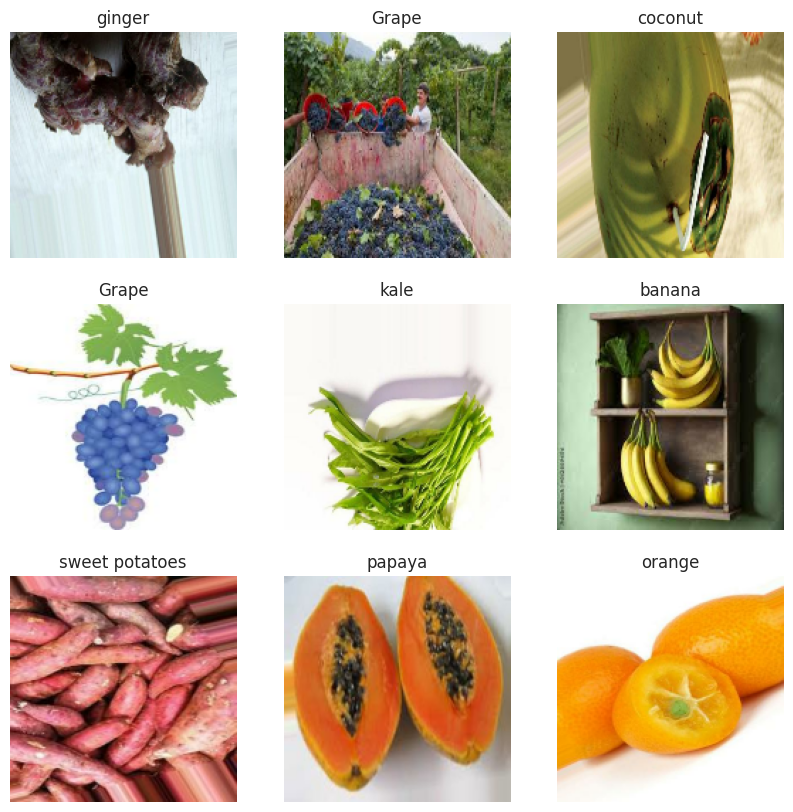

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [29]:
# for image_batch, labels_batch in train_ds:
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     break
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 101
Number of test batches: 97


In [30]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)



# Model

In [32]:
num_classes = len(class_names)

from tensorflow.keras import layers

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50

base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model


data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

In [33]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [34]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [35]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 33)


In [36]:

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 33)             │        42,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,300,257 (8.77 MB)

 Trainable params: 42,273 (165.13 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [37]:
len(model.trainable_variables)

2

In [38]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
epochs = 20

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]  # Use early stopping
)


/home/junwei/Documents/1. Project/Code/Python/Plant_Classifier/venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.0310 - loss: 4.1033
initial loss: 4.09
Epoch 1/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.2448 - loss: 2.8198 - val_accuracy: 0.6892 - val_loss: 1.1611
Epoch 2/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6703 - loss: 1.1650 - val_accuracy: 0.7768 - val_loss: 0.7922
Epoch 3/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.7394 - loss: 0.8777 - val_accuracy: 0.8102 - val_loss: 0.6499
Epoch 4/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.7782 - loss: 0.7470 - val_accuracy: 0.8319 - val_loss: 0.5658
Epoch 5/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.7959 - loss: 0.6704 - val_accuracy: 0.8483 - val_loss: 0.5090
Epoch 6/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.8130 - loss: 0.6093 - val_accuracy: 0.8520 - val_loss: 0.4743
Epoch 7/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.8261 - loss: 0.5685 - val_accuracy: 0.8594 

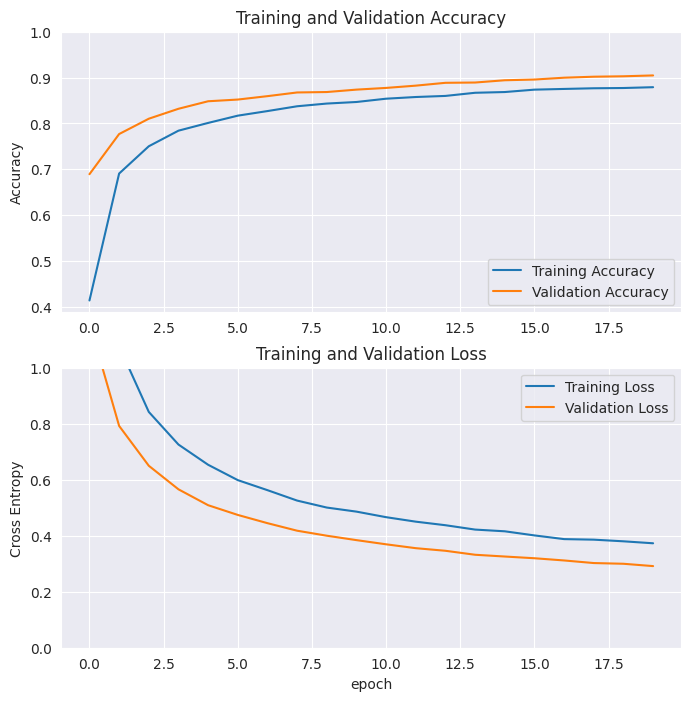

In [40]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step


2024-04-10 10:00:34.702007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


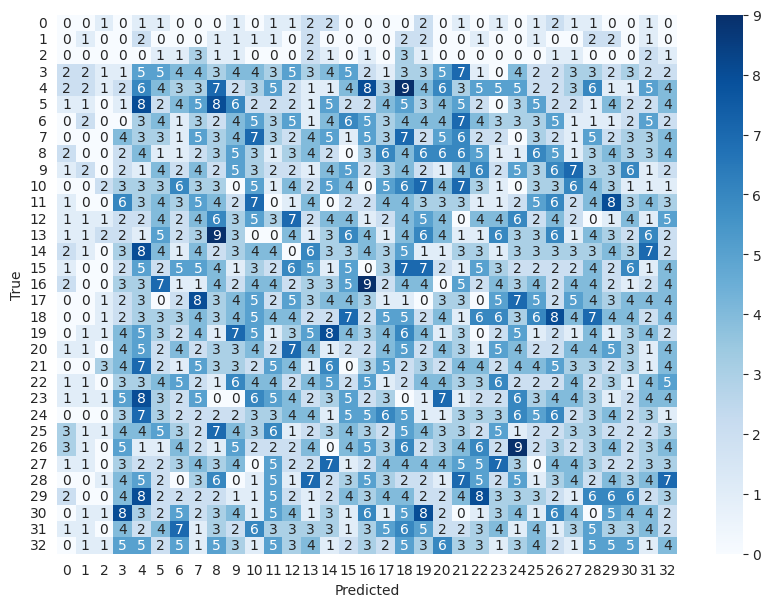

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = np.argmax(model.predict(test_dataset), axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

cm = confusion_matrix(y_true, y_pred)

# Plotting as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [42]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9065 - loss: 0.2987
Test accuracy : 0.913169801235199


Predictions:
 [17 26 11 11 13  7 18  8 18  9 26  3  6 32 16 24 21 14  3 10 20  6 16 12
 12  7 31 28 11 16 19 11]
Labels:
 [17 26 11 11 13  7 18  8 18  9 13  3  6 32 16 24 21 11  3 10 20  6 16 12
 12  7 31 28 11 30 19 30]


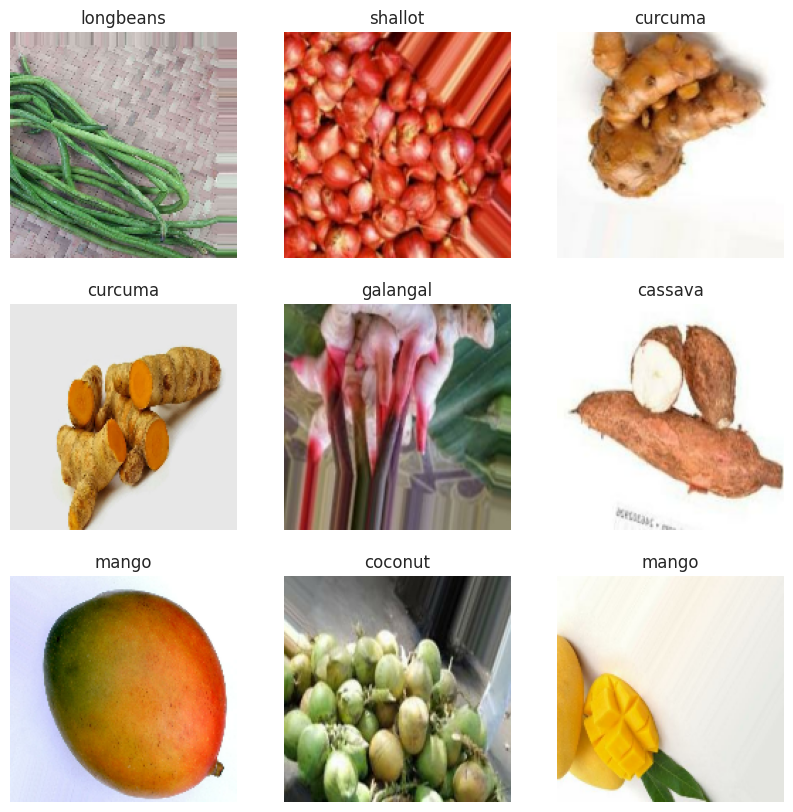

In [43]:
import numpy as np

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply softmax to the predictions
predictions = tf.nn.softmax(predictions, axis=-1)

# Get the class with the highest probability for each prediction
predictions = np.argmax(predictions, axis=-1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")


In [44]:
test_image = 'test_img/banana.jpg'
img = keras.preprocessing.image.load_img(
    test_image, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
This image most likely belongs to banana with a 7.82 percent confidence.


In [45]:
# Save the model to .keras
model.save('model.keras')


In [50]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import time

# Open a video capture object
cap = cv2.VideoCapture(0)

prev_time = time.time()
class_name = ""
confidence = 0

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()

    if not ret:
        break

    # Check if 1 second has passed since the last prediction
    if time.time() - prev_time >= 1:
        # Preprocess the frame to match the model's input requirements
        img = cv2.resize(frame, (img_height, img_width))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create a batch

        # Make a prediction using the model
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        # Get the class with the highest probability
        class_name = class_names[np.argmax(score)]
        confidence = 100 * np.max(score)

        # Print the prediction result to the console
        print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_name, confidence))

        # Update the time of the last prediction
        prev_time = time.time()

    # Write the prediction on the frame
    cv2.putText(frame, "{} {:.2f}%".format(class_name, confidence), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the frame in a window
    cv2.imshow('Webcam Feed', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object
cap.release()

# Destroy all windows
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
This image most likely belongs to tobacco with a 5.92 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
This image most likely belongs to tobacco with a 5.46 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
This image most likely belongs to tobacco with a 7.42 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
This image most likely belongs to banana with a 4.49 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
This image most likely belongs to banana with a 6.23 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
This image most likely belongs to banana with a 4.89 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
This image most likely belongs to banana with a 6.29 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
This image most likely belongs to banana with a 6.59 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
This image most likely belongs to banana with a 6.49 percent confidence